In [328]:
import sys
from pathlib import Path

In [329]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports

In [330]:
import os

In [331]:
import numpy as np
from functools import partial
from tqdm.autonotebook import tqdm

In [332]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.wrappers.bbox import BBox
from chequeparser.utilities.ds_utils import concat_ds

In [333]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS
from chequeparser.datasets.base import BaseDS

In [455]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_RECOG_PRETRAINED, DOCTR_DETECT_PRETRAINED
from chequeparser.models.detection.ultralytics import UltralyticsDetect
from chequeparser.models.detection.doctr import DoctrDetect
from chequeparser.models.recognition.doctr import DoctrRecognize
from chequeparser.models.detection.gcv import GCVDetect
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize
from chequeparser.utilities.io_utils import save_dets, load_dets
from chequeparser.datasets.loaders import load_yolo

In [335]:
import pkg_resources
from symspellpy import SymSpell

## config

In [518]:
dir_images = "../data/public/images/"
dir_sav = "temp/"
f_dataset_yml = "../data/public/dataset.yml"
f_roi_dets_sav = os.path.join(dir_sav, "roi_dets.h5")
f_words_dets_sav = os.path.join(dir_sav, "words_dets.h5")
f_gcv_dets_sav = os.path.join(dir_sav, "gcv_dets.h5")
f_true_anchor_dets_sav = os.path.join(dir_sav, "true_anchor_dets.h5")
f_bkp_anchor_dets_sav = os.path.join(dir_sav, "bkp_anchor_dets.h5")
f_bkp2_anchor_dets_sav = os.path.join(dir_sav, "bkp2_anchor_dets.h5")
f_true_payee_dets_sav = os.path.join(dir_sav, "true_payee_dets.h5")
f_false_payee_dets_sav = os.path.join(dir_sav, "false_payee_dets.h5")

## load ds

In [337]:
all_ds = FileDS(dir_images)

  0%|          | 0/235 [00:00<?, ?it/s]

2024-02-20 12:02:00.042 | INFO     | chequeparser.utilities.io_utils:get_image_files:34 - Found 235 image files.


In [338]:
rand_id = 10

In [339]:
single_ds = all_ds.get_as_ds(rand_id)

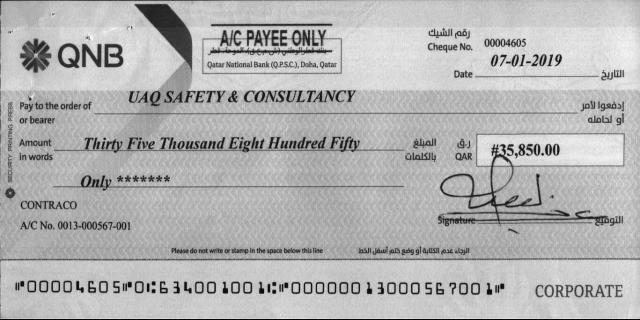

In [340]:
single_ds[0]

## load models

In [341]:
roi_model = UltralyticsDetect("../pretrained/best.pt", arch=UL_RTDETR)

In [342]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
words_model = DoctrDetect(path="db_resnet50", 
                          arch=DOCTR_DETECT_PRETRAINED, 
                          arch_config = doctr_det_arch_config)

In [361]:
rec_model = DoctrRecognize(path="crnn_vgg16_bn", arch=DOCTR_RECOG_PRETRAINED)

In [457]:
gcv_model = GCVDetect(svc_acc_path="../../secrets/sva.json")

In [344]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
spell_checker = partial(sym_spell.lookup_compound,
                        max_edit_distance=2, 
                        transfer_casing=True,
                        split_by_space=True,
                        ignore_non_words=True,
                        ignore_term_with_digits=True
                       )
op_spell_check = lambda x: spell_checker(x)[0].term

## run and save model outputs

In [324]:
# l_roi_dets = []
# for res in tqdm(detect(roi_model, all_ds, stream=True,
#                        verbose=False),
#               total=len(all_ds)):
#     l_roi_dets.append(res)

  0%|          | 0/4 [00:00<?, ?it/s]

In [350]:
l_roi_dets, all_ds = load_yolo(f_dataset_yml)

2024-02-20 12:05:11.958 | INFO     | chequeparser.datasets.loaders:load_yolo:23 - Loading labels from ../data/public/labels


  0%|          | 0/236 [00:00<?, ?it/s]

2024-02-20 12:05:11.976 | INFO     | chequeparser.utilities.io_utils:get_files:35 - Found 235 files.


In [351]:
save_dets(l_roi_dets, f_roi_dets_sav)

2024-02-20 12:05:14.068 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/roi_dets.h5


In [352]:
l_words_dets = []
for res in tqdm(detect(words_model, all_ds, stream=True),
              total=len(all_ds)):
    l_words_dets.append(res)

2024-02-20 12:05:22.970 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: True
2024-02-20 12:05:22.971 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-20 12:05:22.972 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 235 samples


  0%|          | 0/235 [00:00<?, ?it/s]

In [362]:
for words_dets in tqdm(l_words_dets):
    temp_ds = words_dets.create_ds(all_ds)
    temp_ds.batched = True
    l_recs = recognize(rec_model, temp_ds, stream=False, verbose=False)
    _ = [box.set_text_and_confidence(rec_results)
     for box, rec_results in zip(words_dets.bboxes, l_recs)]

  0%|          | 0/235 [00:00<?, ?it/s]

In [363]:
save_dets(l_words_dets, f_words_dets_sav)

2024-02-20 13:14:17.488 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/words_dets.h5


In [459]:
l_gcv_dets = []
for res in tqdm(detect(gcv_model, all_ds, stream=True),
              total=len(all_ds)):
    l_gcv_dets.append(res)

Reloading 'chequeparser.models.detection.gcv'.


2024-02-20 13:45:34.918 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: True
2024-02-20 13:45:34.919 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-20 13:45:34.919 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 235 samples


  0%|          | 0/235 [00:00<?, ?it/s]

In [461]:
save_dets(l_gcv_dets, f_gcv_dets_sav)

2024-02-20 13:51:37.238 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/gcv_dets.h5


## load dets

In [364]:
l_roi_dets = load_dets(f_roi_dets_sav)

In [365]:
l_words_dets = load_dets(f_words_dets_sav)

In [463]:
len(l_gcv_dets), len(l_roi_dets)

(235, 235)

## extract features

### anchor features

In [367]:
l_anchor_roi_dets = [roi_dets.filter_by_labels(["orderof"], split=True)[0]
                     for roi_dets in l_roi_dets]

In [368]:
l_left_half_anchor_rois = [anchor_roi_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for anchor_roi_dets in l_anchor_roi_dets]
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for words_dets in l_words_dets]

In [369]:
l_words_inside_rois = [[
                        l_h_w_dets.filter_by_bbox(bbox, thresh=0.7)
                        for bbox in l_h_a_rois.bboxes]
                       for l_h_w_dets, l_h_a_rois in zip(l_left_half_words_dets,
                                                         l_left_half_anchor_rois)
                      ]

In [370]:
l_anchor_scores = [[sum([1 if keyword in bbox.text.lower() else 0 
                      for keyword in ["pay", "to", "the", "order", "of"]
                      for bbox in dets.bboxes])
                 for dets in words_inside_rois]
                for words_inside_rois in l_words_inside_rois]

In [371]:
l_selected_anchor_ids = [max(range(len(anchor_scores)), 
                             key=lambda x : anchor_scores[x])
                         if len(anchor_scores) > 0 else None
                         for anchor_scores in l_anchor_scores]


In [372]:
l_selected_anchor_rois = [rois.filter_by_idxs([idx])
                          if idx is not None else rois.empty()
                          for idx, rois in zip(l_selected_anchor_ids, 
                                               l_left_half_anchor_rois)]


In [373]:
l_spell_corr_left_half_words_dets = [
    left_half_words_dets.empty() for left_half_words_dets
    in l_left_half_words_dets]

In [374]:
for lh_dets, spell_dets in zip(l_left_half_words_dets,
                               l_spell_corr_left_half_words_dets):
    spell_dets.bboxes = [
        box.apply_text_op(op_spell_check, lowercase=True)
        for box in lh_dets.bboxes
    ]

In [375]:
l_bkp_anchor_dets = [
    dets.filter_by_bbox_text("order").filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

In [391]:
l_bkp2_anchor_dets = [
    dets.filter_by_bbox_text("pay", True).filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

Reloading 'chequeparser.wrappers.detection_results'.


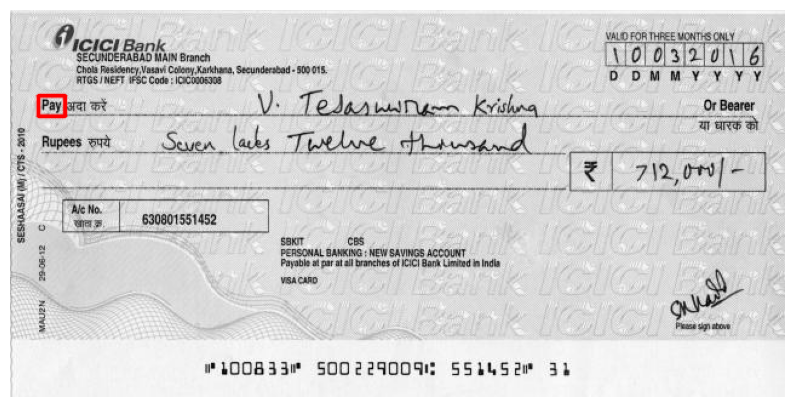

In [404]:
l_bkp2_anchor_dets[111].draw(all_ds)

In [405]:
save_dets(l_selected_anchor_rois, f_true_anchor_dets_sav)

2024-02-20 13:27:03.852 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/true_anchor_dets.h5


In [406]:
save_dets(l_bkp_anchor_dets, f_bkp_anchor_dets_sav)
save_dets(l_bkp2_anchor_dets, f_bkp2_anchor_dets_sav)

2024-02-20 13:27:04.739 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/bkp_anchor_dets.h5
2024-02-20 13:27:04.792 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/bkp2_anchor_dets.h5


## true payee features

In [407]:
l_payee_roi_dets = [roi_dets.filter_by_labels(["payee"], split=True)[0]
                     for roi_dets in l_roi_dets]

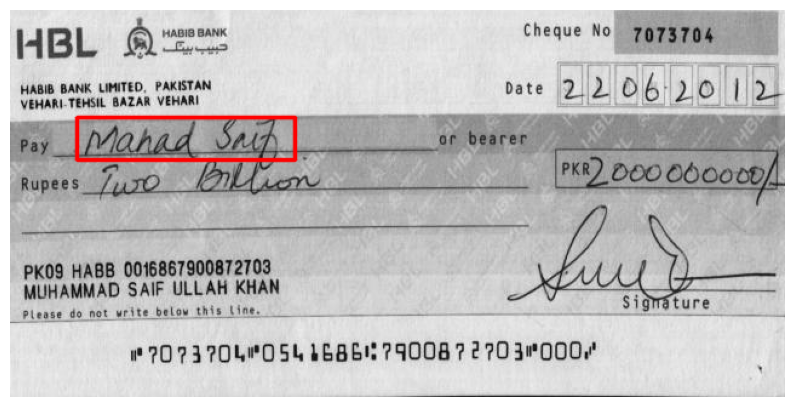

In [411]:
l_payee_roi_dets[10].draw(all_ds)

In [412]:
l_eligible_payee_rois = [payee_roi_dets.filter_by_conf(0.6)
                         for payee_roi_dets in l_payee_roi_dets]

In [413]:
l_high_conf_payee_rois = [payee_roi_dets.filter_by_conf(0.89).filter_by_labels(labels=["payee"],
                                                                              only_max_conf=True,
                                                                              split=False)
                         for payee_roi_dets in l_payee_roi_dets]

In [464]:
l_words_inside_h_c_p_rois = [
    words_dets.filter_by_bbox(dets.bboxes[0]).sort_bboxes_lr().group_bboxes() if len(dets) > 0
    else words_dets.empty()
    for words_dets, dets in zip(l_gcv_dets, l_high_conf_payee_rois)
]

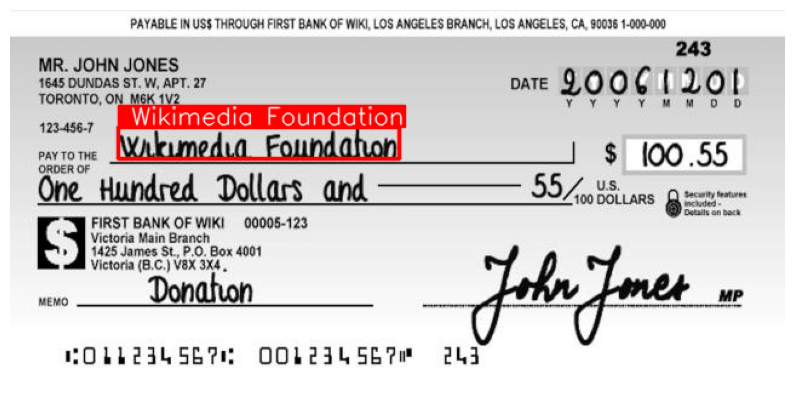

In [477]:
l_words_inside_h_c_p_rois[99].draw(all_ds, show_text=True)

In [479]:
save_dets(l_words_inside_h_c_p_rois, f_true_payee_dets_sav)

2024-02-20 15:16:23.496 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/true_payee_dets.h5


## false payee feature

In [515]:
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.1, 0.6, 0.9)
                           for words_dets in l_gcv_dets]

In [516]:
l_l_h_w_not_inside_roi_dets = [
    words_dets.filter_by_bbox(dets.bboxes[0], inside=False).sort_bboxes_lr().group_bboxes(detect_lines=True)
    if len(dets) > 0 else words_dets.empty()
    for words_dets, dets in zip(l_left_half_words_dets, l_high_conf_payee_rois)
]

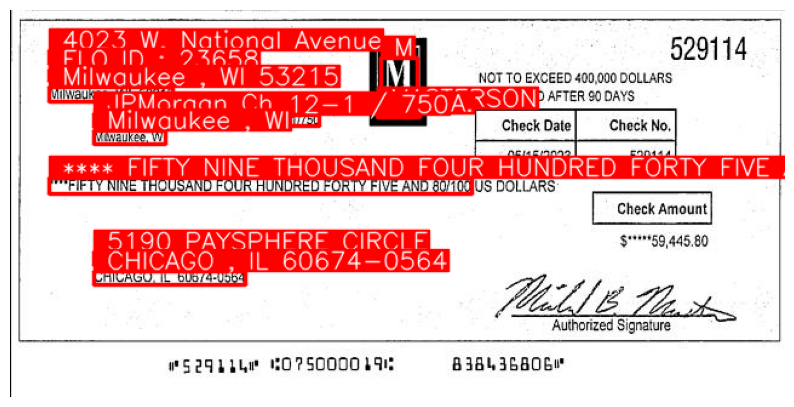

In [517]:
l_l_h_w_not_inside_roi_dets[40].draw(all_ds, show_text=True)

In [519]:
save_dets(l_l_h_w_not_inside_roi_dets, f_false_payee_dets_sav)

2024-02-20 15:43:43.270 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/false_payee_dets.h5
